In [ ]:
import requests
import json
import pandas as pd
import re
import time
import os
import random
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize
import csv

# Set up necessary directories and configurations
os.makedirs('data', exist_ok=True)
session = requests.Session()
retries = Retry(total=3, backoff_factor=1, status_forcelist=[500, 502, 503, 504])
session.mount('http://', HTTPAdapter(max_retries=retries))
session.mount('https://', HTTPAdapter(max_retries=retries))
nltk.download('punkt')

# Function to clean title by standardizing the "By H. P. Lovecraft" text
def clean_title(title):
    author_text = "By H. P. Lovecraft"
    # Remove duplicate "By H. P. Lovecraft" and standardize spacing
    title = re.sub(rf"({author_text}\s*)+", author_text, title).strip()
    if title.endswith(author_text) and not title.endswith(" " + author_text):
        title = title.replace(author_text, " " + author_text)
    return title

# --- Step 1: Scraping Lovecraft Works ---

def scrape_lovecraft_content(content_type):
    base_url = "https://www.hplovecraft.com/writings/texts/"
    response = session.get(base_url)
    
    if response.status_code != 200:
        print(f"Failed to access the base URL: {response.status_code}")
        return
    
    soup = BeautifulSoup(response.content, 'html.parser')
    content_links = [
        f"{base_url}{link['href']}"
        for link in soup.find_all('a', href=True)
        if link['href'].startswith(f'{content_type}/') and not link['href'].startswith('#')
    ]

    csv_filename = f'data/lovecraft_{content_type}.csv'
    with open(csv_filename, 'w', newline='', encoding='utf-8') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(['Content Type', 'Title', 'Text'])

        for content_url in content_links:
            time.sleep(random.uniform(1, 3))
            try:
                content_response = session.get(content_url, headers={'User-Agent': 'Mozilla/5.0'})
                if content_response.status_code == 200:
                    content_soup = BeautifulSoup(content_response.content, 'html.parser')
                    title_tag = content_soup.find('font', size="+2")
                    author_tag = content_soup.find('font', size="+1")
                    text_div = content_soup.find('div', align='justify')

                    if title_tag and text_div:
                        title = f"{title_tag.get_text(strip=True)} by {author_tag.get_text(strip=True)}"
                        title = clean_title(title)  # Clean the title text
                        csvwriter.writerow([content_type, title, text_div.get_text(strip=True)])
                        print(f'Scraped: {title}')
                    else:
                        print(f'Title or text not found for {content_url}')
                else:
                    print(f'Failed to scrape {content_url}: {content_response.status_code}')
            except Exception as e:
                print(f'Error scraping {content_url}: {e}')

# Scrape for all specified content types
for content in ['fiction', 'poetry', 'essays', 'letters']:
    scrape_lovecraft_content(content)

# --- Step 2: API Data Collection ---

def fetch_and_save_json(api_url, filename):
    response = session.get(api_url)
    if response.status_code == 200:
        with open(f'data/{filename}.json', 'w', encoding='utf-8') as file:
            json.dump(response.json(), file, ensure_ascii=False, indent=4)
        print(f"{filename.capitalize()} data saved successfully!")
    else:
        print(f"Failed to retrieve {filename} data: {response.status_code}")

api_categories = {
    "creatures": "https://lovecraftapirest.fly.dev/api/creatures",
    "races": "https://lovecraftapirest.fly.dev/api/races",
    "outer_gods": "https://lovecraftapirest.fly.dev/api/categories/outer-gods",
    "great_old_ones": "https://lovecraftapirest.fly.dev/api/categories/great-old-ones",
    "lesser_old_ones": "https://lovecraftapirest.fly.dev/api/categories/lesser-old-ones"
}

for name, url in api_categories.items():
    fetch_and_save_json(url, name)


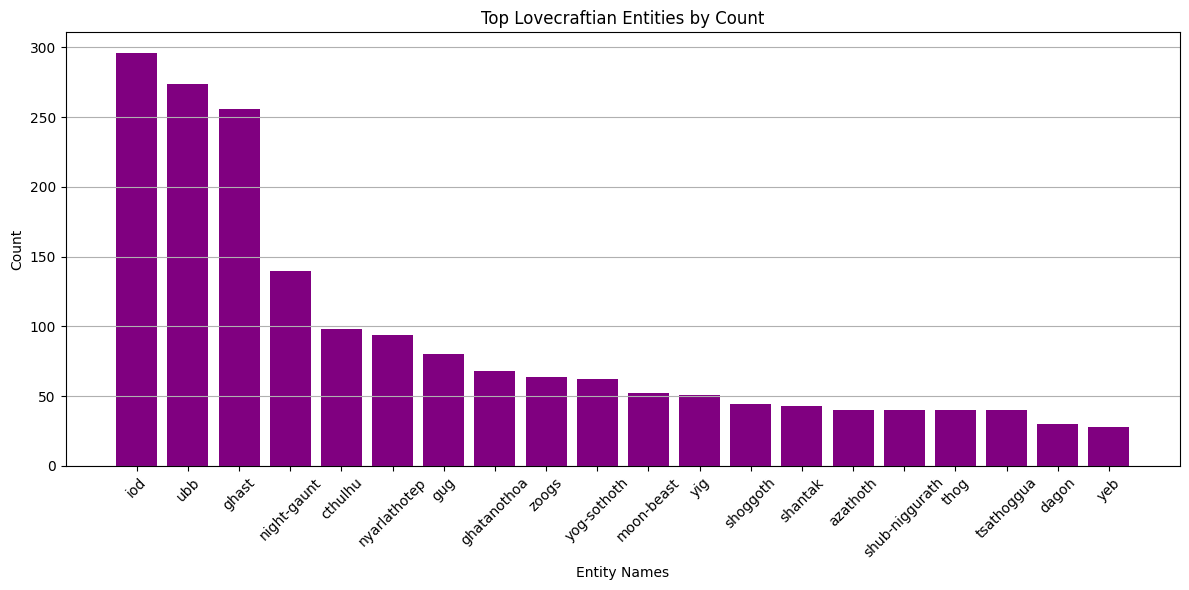

In [23]:
import json
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

# --- Step 3: Load and Clean Data ---
# Load JSON files
with open('data/creatures.json') as f:
    creatures = json.load(f)

with open('data/great_old_ones.json') as f:
    great_old_ones = json.load(f)

with open('data/lesser_old_ones.json') as f:
    lesser_old_ones = json.load(f)

with open('data/outer_gods.json') as f:
    outer_gods = json.load(f)

with open('data/races.json') as f:
    races = json.load(f)

# Load CSV file with Lovecraft fiction
lovecraft_data = pd.read_csv('data/lovecraft_fiction.csv')

# Combine all entity names and add a 'Type' for each entity
all_entities = []

# Add creatures with type 'Creature'
all_entities.extend([{'name': creature['name'], 'type': 'Creature'} for creature in creatures])

# Add Great Old Ones with type 'Great Old One'
all_entities.extend([{'name': old_one['name'], 'type': 'Great Old One'} for old_one in great_old_ones])

# Add Lesser Old Ones with type 'Lesser Old One'
all_entities.extend([{'name': old_one['name'], 'type': 'Lesser Old One'} for old_one in lesser_old_ones])

# Add Outer Gods with type 'Outer God'
all_entities.extend([{'name': old_one['name'], 'type': 'Outer God'} for old_one in outer_gods])

# Add races with type 'Race'
all_entities.extend([{'name': race['race'], 'type': 'Race'} for race in races])

# Clean names to lowercase for case-insensitive matching and merge ghoul entities
all_names = [entity['name'].lower() for entity in all_entities]
all_types = [entity['type'] for entity in all_entities]

# Merge plural forms and combine duplicates
def clean_name(name):
    name_corrections = {
        'ghoul': 'ghoul',
        'dark young': 'dark young of shub-niggurath',
        'deep one': 'deep one',
        'dimensional shambler': 'dimensional shambler',
        'elder thing': 'elder thing',
        'flying polyp': 'flying polyp',
        'ghast': 'ghast',
        'gug': 'gug',
        'hound of tindalos': 'hound of tindalos',
        'moon-beast': 'moon-beast',
        'night-gaunt': 'night-gaunt',
        'shoggoth': 'shoggoth',
        'spider of leng': 'spider of leng',
        'star spawn of cthulhu': 'star spawn of cthulhu',
        'tcho-tcho': 'tcho-tcho'
    }
    # Clean the name to ensure it matches the corrected form
    for singular, corrected in name_corrections.items():
        if singular in name:
            return corrected
    return name

# Apply the cleaning function to the list of names
all_names = [clean_name(name) for name in all_names]

# Drop unwanted terms: 'han', 'ghoul', and 'darkness'
unwanted_terms = ['han', 'ghoul', 'darkness']
all_names = [name for name in all_names if name not in unwanted_terms]

# --- Step 4: Filter Texts by Names and Count Occurrences ---
def filter_texts(data_frame, names):
    return [text for text in data_frame['Text'] if any(name in text.lower() for name in names)]

filtered_texts = filter_texts(lovecraft_data, all_names)

# Count occurrences with merged ghoul entities and cleaned names
name_counts = Counter()
for text in filtered_texts:
    for name in all_names:
        name_counts[name] += text.lower().count(name)

# Create a DataFrame for name counts
name_counts_df = pd.DataFrame(name_counts.items(), columns=['Name', 'Count'])

# Add the 'Type' column based on name matching
name_counts_df['Type'] = name_counts_df['Name'].apply(
    lambda name: all_types[all_names.index(name)] if name in all_names else 'Unknown'
)

# Save the name counts with types
name_counts_df.to_csv('data/lovecraft_name_counts.csv', index=False)

# --- Step 5: Visualization ---
def plot_top_entities(counts_df, top_n=10, exclude=None):
    exclude = exclude or []
    filtered_df = counts_df[~counts_df['Name'].isin(exclude)]
    top_entities = filtered_df.nlargest(top_n, 'Count')

    plt.figure(figsize=(12, 6))
    plt.bar(top_entities['Name'], top_entities['Count'], color='purple')
    plt.title('Top Lovecraftian Entities by Count')
    plt.xlabel('Entity Names')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

# Load updated name counts if needed and plot
plot_top_entities(name_counts_df, top_n=20, exclude=['darkness'])


In [2]:
import pandas as pd

# Load CSV:
name_counts_df = pd.read_csv('data/lovecraft_name_counts.csv')

# Show the top 10 most common entities
top_entities = name_counts_df.sort_values(by='Count', ascending=False).head(10)
print(top_entities)

# Show the least common entities
least_common_entities = name_counts_df.sort_values(by='Count', ascending=True).head(10)
print(least_common_entities)

# You can also filter by entity type (if it's included in your dataset)
# For example, if you have a 'Type' column:
# lovecraft_data_filtered = name_counts_df[name_counts_df['Type'] == 'Great Old One']


             Name  Count      Type
46            iod    296  Creature
99            ubb    274  Creature
29          ghast    256  Creature
61    night-gaunt    140  Creature
15        cthulhu     98  Creature
65   nyarlathotep     94  Creature
39            gug     80  Creature
30    ghatanothoa     68  Creature
115         zoogs     64  Creature
112   yog-sothoth     62  Creature
               Name  Count      Type
0    'umr at-tawill      0  Creature
1            abhoth      0  Creature
2      apocolothoth      0  Creature
3     atlach-natcha      0  Creature
5           basatan      0  Creature
7           byakhee      0  Creature
9   cat from saturn      0  Creature
8            byatis      0  Creature
14          cthugha      0  Creature
12        chthonian      0  Creature


In [3]:
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback

# Load CSV file:
df = pd.read_csv('data/lovecraft_name_counts.csv')

names = df['Name'].tolist()

# Clean up and prepare 'Name' for character-level tokenization:
names = [name.replace(" ", "") for name in names]  # Remove spaces.
all_chars = ''.join(names)
vocab = sorted(set(all_chars))  # Unique characters.
char_to_idx = {char: idx for idx, char in enumerate(vocab)}  # Mapping chars to indices.
idx_to_char = {idx: char for char, idx in char_to_idx.items()}  # Reverse mapping.

# Generate input-output sequences:
seq_length = 5  # Length of character sequences used to predict next character:
X = []
y = []
for name in names:
    for i in range(len(name) - seq_length):
        X.append([char_to_idx[char] for char in name[i:i + seq_length]])
        y.append(char_to_idx[name[i + seq_length]])

X = np.array(X)
y = np.array(y)

# Reshape X for LSTM model input (samples, time steps, features):
X = X.reshape((X.shape[0], X.shape[1], 1)) / len(vocab)  # Normalize the input.

# One-hot encode the labels:
y = tf.keras.utils.to_categorical(y, num_classes=len(vocab))

# Define the LSTM model with more layers and units:
model = Sequential()
model.add(LSTM(128, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(Dropout(0.2))  # Dropout layer to prevent overfitting.
model.add(LSTM(128, return_sequences=False))  # Second LSTM layer.
model.add(Dense(len(vocab), activation='softmax'))  # Output layer.
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Custom callback to track highest accuracy
class HighestAccuracyCallback(Callback):
    def __init__(self):
        super().__init__()
        self.highest_accuracy = 0.0
    
    def on_epoch_end(self, epoch, logs=None):
        current_accuracy = logs.get("accuracy")
        if current_accuracy and current_accuracy > self.highest_accuracy:
            self.highest_accuracy = current_accuracy
    
    def on_train_end(self, logs=None):
        print(f"Highest accuracy achieved: {self.highest_accuracy:.4f}")

# Instantiate the callback
highest_accuracy_callback = HighestAccuracyCallback()

# Train model with the custom callback
model.fit(X, y, epochs=1000, batch_size=64, callbacks=[highest_accuracy_callback])

# Define function to generate entity names (same as provided in your code)
def generate_entity_name(length=10, temperature=1.0):
    # Define invalid starting and ending characters:
    invalid_chars = ["'", "-", " "]

    # Start from a random character in the vocabulary:
    start_idx = random.randint(0, len(vocab) - 1)
    seed = idx_to_char[start_idx]  # Start the name from this random character.
    
    # Ensure name does not start with invalid character:
    while seed in invalid_chars:
        start_idx = random.randint(0, len(vocab) - 1)
        seed = idx_to_char[start_idx]

    # Initialize seed as a list of indices:
    encoded_seed = [start_idx]  # Convert character to index.

    generated_name = seed  # Initialize generated name with the first character.
    
    # Ensure there are enough characters in encoded_seed for model:
    while len(encoded_seed) < seq_length:
        # Add a random character to the seed if it's too short.
        encoded_seed.append(random.randint(0, len(vocab) - 1))
    
    # Generate characters one at a time:
    for _ in range(length):
        input_seq = np.array(encoded_seed[-seq_length:]).reshape(1, seq_length, 1) / len(vocab)  # Prepare input for LSTM.
        predicted_prob = model.predict(input_seq, verbose=0)[0]  # Get prediction probabilities.

        # Apply temperature to the probabilities:
        predicted_prob = np.asarray(predicted_prob).astype('float64')
        predicted_prob = np.log(predicted_prob + 1e-7) / temperature  # Add small value to avoid log(0).
        predicted_prob = np.exp(predicted_prob) / np.sum(np.exp(predicted_prob))  # Normalize probabilities.

        # Sample next character:
        predicted_char_idx = np.random.choice(len(predicted_prob), p=predicted_prob)
        predicted_char = idx_to_char[predicted_char_idx]
        
        generated_name += predicted_char
        encoded_seed.append(predicted_char_idx)  # Update seed with predicted character.

    # Post-process to remove consecutive duplicates:
    def remove_consecutive_duplicates(name):
        result = []
        for char in name:
            if not result or result[-1] != char:
                result.append(char)
        return ''.join(result)

    generated_name = remove_consecutive_duplicates(generated_name).strip()

    # Capitalize first letter, and lowercase rest of name (after apostrophe if any):
    generated_name = generated_name.capitalize()  # Capitalize the first letter of the name.

    # Ensure apostrophes are used only in the middle of the name:
    if "'" in generated_name:
        parts = generated_name.split("'")
        if len(parts) > 2 or parts[0] == "" or parts[-1] == "":  # Avoid multiple apostrophes or apostrophes at start/end.
            return generate_entity_name(length, temperature)  # Recursively regenerate if apostrophe misuse detected.
        parts[1] = parts[1].lower()  # Lowercase after apostrophe.
        generated_name = "'".join(parts)

    # Ensure generated name doesn't end with an invalid character:
    if generated_name[-1] in invalid_chars:
        return generate_entity_name(length, temperature)  # Regenerate if it ends with invalid char.

    return generated_name

# Generate Sample Name:
new_entity = generate_entity_name(length=10, temperature=0.7)
print(f"Sample Name: {new_entity}")


Epoch 1/1000


c:\Users\Marc Jay\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.0617 - loss: 3.3186
Epoch 2/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0987 - loss: 3.1649 
Epoch 3/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0908 - loss: 2.9820 
Epoch 4/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1203 - loss: 2.9041 
Epoch 5/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0967 - loss: 2.9228 
Epoch 6/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1150 - loss: 2.9214 
Epoch 7/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1202 - loss: 2.9128 
Epoch 8/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0557 - loss: 2.9280 
Epoch 9/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1051 - loss: 2.8918 
Epoch 10/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1153 - loss: 2.9168 
Epoch 11/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0939 - loss: 2.9285 
Epoch 12/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - 

In [4]:
# Save 'final' model:
model.save('final_model.keras')

In [5]:
# Attributes for entities:
races = ["Elder God", "Shoggoth", "Night Gaunt", "Deep One", "Great Old One", "Cosmic Horror"]
powers = ["Mighty", "Weak", "Ancient", "Vast", "Primordial", "Frail"]
domains = ["Cosmic Abyss", "The Void", "Earth's Oceans", "Dream Realms", "The Stars", "Dark Cosmos"]
physical_traits = ["Amorphous", "Tentacled", "Winged", "Eyeless", "Eyes of Madness", "Unseen"]
alignments = ["Malevolent", "Neutral", "Indifferent", "Benevolent"]

# Generate a random set of attributes:
def generate_entity_attributes():
    race = random.choice(races)
    power = random.choice(powers)
    domain = random.choice(domains)
    traits = random.sample(physical_traits, 2)
    alignment = random.choice(alignments)
    
    return {
        "race": race,
        "power": power,
        "domain": domain,
        "physical_traits": traits,
        "alignment": alignment
    }

def generate_entity_name_with_attributes(length=10, temperature=1.0):
    # Generate entity name first:
    generated_name = generate_entity_name(length=length, temperature=temperature)

    # Generate the entity's characteristics:
    attributes = generate_entity_attributes()
    
    # Combine name and characteristics:
    entity_details = {
        "name": generated_name,
        "race": attributes["race"],
        "power": attributes["power"],
        "domain": attributes["domain"],
        "physical_traits": ', '.join(attributes["physical_traits"]),
        "alignment": attributes["alignment"]
    }
    
    return entity_details

# Generate new entity with name and attributes:
new_entity = generate_entity_name_with_attributes(length=10, temperature=1)
print(f"New Creature: {new_entity['name']}")
print(f"Race: {new_entity['race']}")
print(f"Power: {new_entity['power']}")
print(f"Domain: {new_entity['domain']}")
print(f"Physical Traits: {new_entity['physical_traits']}")
print(f"Alignment: {new_entity['alignment']}")


New Creature: Uedibhanece
Race: Shoggoth
Power: Mighty
Domain: Cosmic Abyss
Physical Traits: Unseen, Eyeless
Alignment: Malevolent
